In [1]:
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import metrics
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df_sample = train_df.sample(2860539)

In [4]:
train_x = train_df_sample.drop(['ID', 'Click'], axis=1)
train_y = train_df_sample['Click']

test_x = test_df.drop(['ID'], axis=1)

In [5]:
for col in tqdm(train_x.columns):
    if train_x[col].isnull().sum() != 0:
        train_x[col].fillna(0, inplace=True)
        test_x[col].fillna(0, inplace=True)

100%|██████████| 39/39 [00:08<00:00,  4.65it/s]


In [6]:
encoding_target = list(train_x.dtypes[train_x.dtypes == "object"].index)

enc = ce.CountEncoder(cols=encoding_target).fit(train_x, train_y)
X_train_encoded = enc.transform(train_x)
X_test_encoded = enc.transform(test_x)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, train_y, test_size=0.15, random_state=9608)

cat = CatBoostClassifier(iterations=10000,
                         learning_rate=0.01,
                         l2_leaf_reg=5e-3,
                         max_depth=16,
                         task_type="GPU",
                         devices='0')

cat.fit(X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

0:	learn: 0.6873386	test: 0.6874404	best: 0.6874404 (0)	total: 1.88s	remaining: 5h 13m 27s
1:	learn: 0.6816653	test: 0.6818707	best: 0.6818707 (1)	total: 2.63s	remaining: 3h 39m 4s
2:	learn: 0.6761858	test: 0.6764499	best: 0.6764499 (2)	total: 3.37s	remaining: 3h 7m 7s
3:	learn: 0.6708260	test: 0.6711553	best: 0.6711553 (3)	total: 4.11s	remaining: 2h 51m 13s
4:	learn: 0.6655304	test: 0.6659813	best: 0.6659813 (4)	total: 4.87s	remaining: 2h 42m 13s
5:	learn: 0.6604225	test: 0.6609569	best: 0.6609569 (5)	total: 5.62s	remaining: 2h 35m 55s
6:	learn: 0.6553927	test: 0.6560249	best: 0.6560249 (6)	total: 6.36s	remaining: 2h 31m 23s
7:	learn: 0.6503458	test: 0.6511751	best: 0.6511751 (7)	total: 7.13s	remaining: 2h 28m 28s
8:	learn: 0.6455380	test: 0.6464572	best: 0.6464572 (8)	total: 7.88s	remaining: 2h 25m 45s
9:	learn: 0.6408353	test: 0.6418642	best: 0.6418642 (9)	total: 8.63s	remaining: 2h 23m 37s
10:	learn: 0.6361686	test: 0.6373494	best: 0.6373494 (10)	total: 9.38s	remaining: 2h 22m 3s
1

In [8]:
preds = cat.predict(X_test)
acc_score = accuracy_score(y_test, preds)
print(acc_score)

score = cat.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, score, pos_label=1)
auc_score = metrics.auc(fpr, tpr)
print(auc_score)

0.8174587082625425
0.7501153299302127


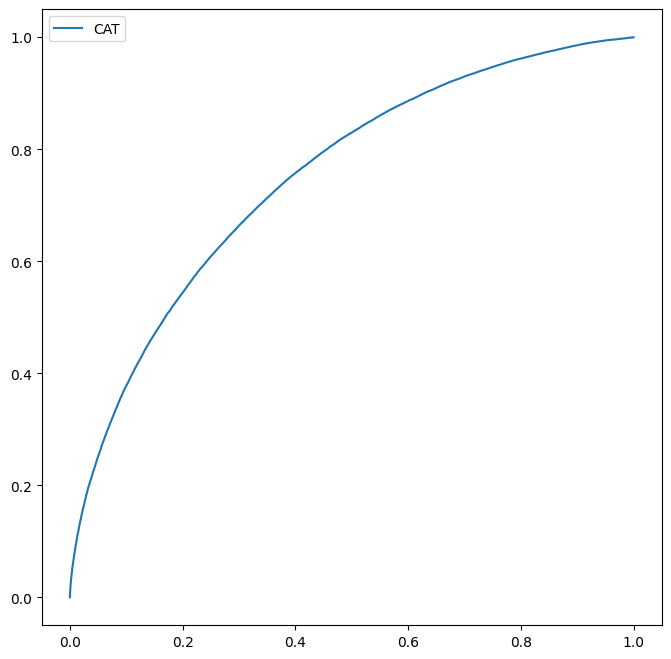

In [9]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(fpr, tpr, label='CAT')
ax.legend()
plt.show()

In [10]:
test_pred = cat.predict_proba(X_test_encoded)

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['Click'] = test_pred[:,1]
sample_submission.to_csv('cat.csv', index=False)